In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download delayedkarma/impressionist-classifier-data
! unzip impressionist-classifier-data.zip

100% 2.18G/2.19G [00:18<00:00, 203MB/s]
100% 2.19G/2.19G [00:18<00:00, 126MB/s]
Archive:  impressionist-classifier-data.zip
  inflating: training/training/Cezanne/215457.jpg  
  inflating: training/training/Cezanne/215458.jpg  
  inflating: training/training/Cezanne/215459.jpg  
  inflating: training/training/Cezanne/215460.jpg  
  inflating: training/training/Cezanne/215462.jpg  
  inflating: training/training/Cezanne/215463.jpg  
  inflating: training/training/Cezanne/215466.jpg  
  inflating: training/training/Cezanne/215467.jpg  
  inflating: training/training/Cezanne/215468.jpg  
  inflating: training/training/Cezanne/215469.jpg  
  inflating: training/training/Cezanne/215470.jpg  
  inflating: training/training/Cezanne/215471.jpg  
  inflating: training/training/Cezanne/215473.jpg  
  inflating: training/training/Cezanne/215474.jpg  
  inflating: training/training/Cezanne/215475.jpg  
  inflating: training/training/Cezanne/215476.jpg  
  inflating: training/training/Cezanne/21547

In [4]:
import numpy as np
import pandas as pd
import os
import torchvision
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torch import Generator
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import itertools
import time
import copy
from torchvision.models import ResNet50_Weights
from torch.nn import Module
from torchvision import models
import torch.optim as optim
import seaborn as sns
import torchvision
import torch.nn as nn
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

In [5]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 6050
setup_seed(SEED)

In [6]:
artists = ['Cezanne', 'Degas', 'Gauguin', 'Hassam', 'Matisse', 'Monet', 'Pissarro', 'Renoir', 'Sargent', 'VanGogh']
artists = os.listdir('training/training')

In [7]:
transformation = Compose([
    Resize((256,256)),
    ToTensor()
])
transformation_train = Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    ToTensor()
])

image_datasets = {}
# for phase in ['training', 'validation']:
#   image_datasets[phase] = ImageFolder(f'/content/{phase}/{phase}', transform=transformation)
image_datasets['training'] = ImageFolder(f'/content/training/training', transform=transformation_train)
image_datasets['validation'] = ImageFolder(f'/content/validation/validation', transform=transformation)

# size_all_train = len(image_datasets['training'])
# size_test_from_train = int(size_all_train * 0.125)
# size_train = size_all_train - size_test_from_train

# image_datasets['training'], image_datasets_test_from_train = random_split(image_datasets['training'], [size_train, size_test_from_train], generator=Generator().manual_seed(SEED))

# size_all_validation = len(image_datasets['validation'])
# size_test_from_validation = int(size_all_validation * 0.25)
# size_validation = size_all_validation - size_test_from_validation

# image_datasets['validation'], image_datasets_test_from_validation = random_split(image_datasets['validation'], [size_validation, size_test_from_validation], generator=Generator().manual_seed(SEED))

# image_datasets['testing'] = ConcatDataset([image_datasets_test_from_train, image_datasets_test_from_validation])

size_all_validation = len(image_datasets['validation'])
size_test_from_validation = int(size_all_validation * 0.5)
size_validation = size_all_validation - size_test_from_validation

image_datasets['validation'], image_datasets['testing'] = random_split(image_datasets['validation'], [size_validation, size_test_from_validation], generator=Generator().manual_seed(SEED))

# EDIT BATCH SIZE HERE (tune learning rate using 16, then, once the learning rate is fixed, try 32, 48, 64)
BS = 32
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BS, shuffle=True) for x in ['training', 'validation', 'testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation', 'testing']}
print(dataset_sizes)

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

{'training': 3988, 'validation': 495, 'testing': 495}
cuda:0


In [8]:
for artist in artists:
    exec(f"train_{artist}_dir = os.path.join('training/training', '{artist}')")
    exec(f"train_{artist}_filenames = os.listdir(train_{artist}_dir)")
    exec(f"valid_{artist}_dir = os.path.join('validation/validation', '{artist}')")
    exec(f"valid_{artist}_filenames = os.listdir(valid_{artist}_dir)")

In [9]:
# define the model training function
def train_model(model, criterion, optimizer, num_epochs=25):
    # initialize the start time
    since = time.time()

    # initialize the best weight configuration and accuracy of the model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # initialize the lists that will store the accuracies and losses across the epochs
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []

    # iterate over the epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluate mode

            # initialize the running losses and corrects
            running_loss = 0.0
            running_corrects = 0

            # iterate over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                # track history if only in train
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward pass
                    # optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                # calculate and update epoch statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # print epoch performance statistics
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # store epoch performance statistics
            if phase == 'training':
              train_accs.append(epoch_acc.item())
              train_losses.append(epoch_loss)
            else:
              val_accs.append(epoch_acc.item())
              val_losses.append(epoch_loss)

            # deep copy the model to reflect the best weight configuration
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # print the training statistics
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_accs, train_losses, val_accs, val_losses

In [10]:
!pip install googlenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
global_LR = 5e-4
global_BS = 32
# global_WD = 1e-5
global_DR = 0.0

In [12]:
BS = 32
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BS, shuffle=True) for x in ['training', 'validation', 'testing']}

In [13]:
from googlenet_pytorch import GoogLeNet
model_google = GoogLeNet.from_pretrained("googlenet")
model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 87.4MB/s]


Loaded pretrained weights for googlenet


## Model 3: WD = 1e-4
- batch_size= 32
- LR = 5e-4
- DR = 0.0
- Data Augmentation

In [14]:
model_google = GoogLeNet.from_pretrained("googlenet")

# freeze all of the parameters in the model
for param in model_google.parameters():
    param.requires_grad = False

# unfreeze the parameters in the last residual block of the architecture
for name, param in model_google.named_parameters():
    for i in [5]:
        if name.startswith(f'inception{5}') or name.startswith('aux'):
            param.requires_grad = True

# EDIT DROPOUT RATE HERE (dropout actually doesn't help here, so let's use L2 regularization instead)
DO = 0.0
# construct the fully connected head which will receive the flattened convolutional output

'''
The final layer of GoogLeNet is a global average pooling layer that reduces the spatial 
dimensions of the feature maps to 1x1 and produces a tensor of size (1, 1024).
''' 
model_google.fc = nn.Sequential(
               nn.Linear(1024, 512), # 2048 -> 1024
               nn.BatchNorm1d(512),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),
               
               nn.Linear(512, 128),
               nn.BatchNorm1d(128),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),

              #  nn.Linear(128, 32),
              #  nn.BatchNorm1d(32),
              #  nn.ReLU(inplace=True),
              #  #nn.Dropout(DO),

               nn.Linear(128, len(artists)))

# print all the named parameters in the model to confirm that the correct ones are frozen and unfrozen
for name, param in model_google.named_parameters():
    print(name, param.requires_grad)

model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet
conv1.conv.weight False
conv1.bn.weight False
conv1.bn.bias False
conv2.conv.weight False
conv2.bn.weight False
conv2.bn.bias False
conv3.conv.weight False
conv3.bn.weight False
conv3.bn.bias False
inception3a.branch1.conv.weight False
inception3a.branch1.bn.weight False
inception3a.branch1.bn.bias False
inception3a.branch2.0.conv.weight False
inception3a.branch2.0.bn.weight False
inception3a.branch2.0.bn.bias False
inception3a.branch2.1.conv.weight False
inception3a.branch2.1.bn.weight False
inception3a.branch2.1.bn.bias False
inception3a.branch3.0.conv.weight False
inception3a.branch3.0.bn.weight False
inception3a.branch3.0.bn.bias False
inception3a.branch3.1.conv.weight False
inception3a.branch3.1.bn.weight False
inception3a.branch3.1.bn.bias False
inception3a.branch4.1.conv.weight False
inception3a.branch4.1.bn.weight False
inception3a.branch4.1.bn.bias False
inception3b.branch1.conv.weight False
inception3b.branch1.bn.weight False
inception3

In [15]:
criterion_3 = nn.CrossEntropyLoss()

# EDIT LEARNING RATE HERE (tune 0.01, 0.001, 0.0001 with batch size of 16)
WD = 1e-4

# set the optimizer for the parameters of the whole model
optimizer_3 = optim.Adam(filter(lambda p: p.requires_grad, model_google.parameters()), lr=global_LR, weight_decay=WD)

In [16]:
model_3, train_accs_3, train_losses_3, val_accs_3, val_losses_3 = train_model(model_google, criterion_3, optimizer_3, num_epochs=7)

Epoch 1/7
----------
training Loss: 1.3030 Acc: 0.5795
validation Loss: 0.8624 Acc: 0.7253

Epoch 2/7
----------
training Loss: 0.8373 Acc: 0.7482
validation Loss: 0.7663 Acc: 0.7434

Epoch 3/7
----------
training Loss: 0.6472 Acc: 0.7971
validation Loss: 0.7794 Acc: 0.7535

Epoch 4/7
----------
training Loss: 0.5689 Acc: 0.8159
validation Loss: 0.7197 Acc: 0.7535

Epoch 5/7
----------
training Loss: 0.4899 Acc: 0.8480
validation Loss: 0.6153 Acc: 0.8061

Epoch 6/7
----------
training Loss: 0.3868 Acc: 0.8849
validation Loss: 0.6536 Acc: 0.8141

Epoch 7/7
----------
training Loss: 0.3514 Acc: 0.8887
validation Loss: 0.5973 Acc: 0.8040

Training complete in 24m 37s
Best val Acc: 0.814141


Text(0.5, 1.0, 'Loss')

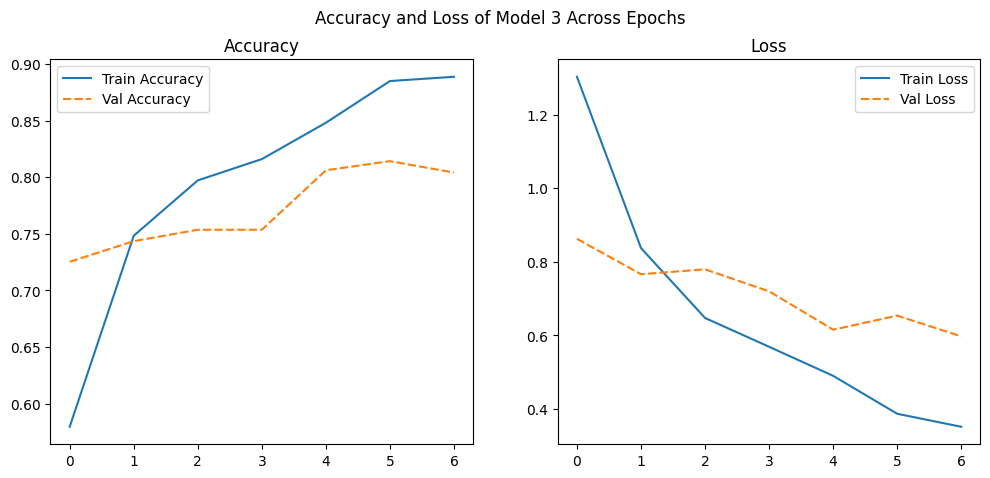

In [17]:
data_acc_3 = pd.DataFrame({"Train Accuracy": train_accs_3, "Val Accuracy": val_accs_3})
data_loss_3 = pd.DataFrame({"Train Loss": train_losses_3, "Val Loss": val_losses_3})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 3 Across Epochs")

sns.lineplot(data=data_acc_3, ax = axs[0])
axs[0].set_title("Accuracy")


sns.lineplot(data=data_loss_3, ax = axs[1])
axs[1].set_title("Loss")

In [18]:
result_3 = pd.concat([data_acc_3, data_loss_3], axis = 1)
result_3

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.579488,0.725253,1.303042,0.862356
1,0.748245,0.743434,0.837269,0.766297
2,0.797141,0.753535,0.647181,0.779439
3,0.815948,0.753535,0.568921,0.719670
4,0.848044,0.806061,0.489853,0.615333
5,0.884905,0.814141,0.386752,0.653620
6,0.888666,0.804040,0.351396,0.597278


## Model 4: WD = 1e-3
- batch_size= 32
- LR = 5e-4
- DR = 0.0
- Data Augmentation

In [19]:
model_google = GoogLeNet.from_pretrained("googlenet")

# freeze all of the parameters in the model
for param in model_google.parameters():
    param.requires_grad = False

# unfreeze the parameters in the last residual block of the architecture
for name, param in model_google.named_parameters():
    for i in [5]:
        if name.startswith(f'inception{5}') or name.startswith('aux'):
            param.requires_grad = True

# EDIT DROPOUT RATE HERE (dropout actually doesn't help here, so let's use L2 regularization instead)
DO = 0.0
# construct the fully connected head which will receive the flattened convolutional output

'''
The final layer of GoogLeNet is a global average pooling layer that reduces the spatial 
dimensions of the feature maps to 1x1 and produces a tensor of size (1, 1024).
''' 
model_google.fc = nn.Sequential(
               nn.Linear(1024, 512), # 2048 -> 1024
               nn.BatchNorm1d(512),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),
               
               nn.Linear(512, 128),
               nn.BatchNorm1d(128),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),

              #  nn.Linear(128, 32),
              #  nn.BatchNorm1d(32),
              #  nn.ReLU(inplace=True),
              #  #nn.Dropout(DO),

               nn.Linear(128, len(artists)))

# print all the named parameters in the model to confirm that the correct ones are frozen and unfrozen
for name, param in model_google.named_parameters():
    print(name, param.requires_grad)

model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet
conv1.conv.weight False
conv1.bn.weight False
conv1.bn.bias False
conv2.conv.weight False
conv2.bn.weight False
conv2.bn.bias False
conv3.conv.weight False
conv3.bn.weight False
conv3.bn.bias False
inception3a.branch1.conv.weight False
inception3a.branch1.bn.weight False
inception3a.branch1.bn.bias False
inception3a.branch2.0.conv.weight False
inception3a.branch2.0.bn.weight False
inception3a.branch2.0.bn.bias False
inception3a.branch2.1.conv.weight False
inception3a.branch2.1.bn.weight False
inception3a.branch2.1.bn.bias False
inception3a.branch3.0.conv.weight False
inception3a.branch3.0.bn.weight False
inception3a.branch3.0.bn.bias False
inception3a.branch3.1.conv.weight False
inception3a.branch3.1.bn.weight False
inception3a.branch3.1.bn.bias False
inception3a.branch4.1.conv.weight False
inception3a.branch4.1.bn.weight False
inception3a.branch4.1.bn.bias False
inception3b.branch1.conv.weight False
inception3b.branch1.bn.weight False
inception3

In [20]:
criterion_4 = nn.CrossEntropyLoss()

# EDIT LEARNING RATE HERE (tune 0.01, 0.001, 0.0001 with batch size of 16)
WD = 1e-3

# set the optimizer for the parameters of the whole model
optimizer_4 = optim.Adam(filter(lambda p: p.requires_grad, model_google.parameters()), lr=global_LR, weight_decay=WD)

In [21]:
model_4, train_accs_4, train_losses_4, val_accs_4, val_losses_4 = train_model(model_google, criterion_4, optimizer_4, num_epochs=7)

Epoch 1/7
----------
training Loss: 1.3128 Acc: 0.5830
validation Loss: 0.9125 Acc: 0.7192

Epoch 2/7
----------
training Loss: 0.8225 Acc: 0.7450
validation Loss: 0.7664 Acc: 0.7394

Epoch 3/7
----------
training Loss: 0.6647 Acc: 0.7904
validation Loss: 0.6404 Acc: 0.7960

Epoch 4/7
----------
training Loss: 0.5548 Acc: 0.8240
validation Loss: 0.7238 Acc: 0.7697

Epoch 5/7
----------
training Loss: 0.4926 Acc: 0.8420
validation Loss: 0.7134 Acc: 0.7758

Epoch 6/7
----------
training Loss: 0.4348 Acc: 0.8583
validation Loss: 0.6426 Acc: 0.8000

Epoch 7/7
----------
training Loss: 0.3585 Acc: 0.8852
validation Loss: 0.6058 Acc: 0.8081

Training complete in 23m 54s
Best val Acc: 0.808081


Text(0.5, 1.0, 'Loss')

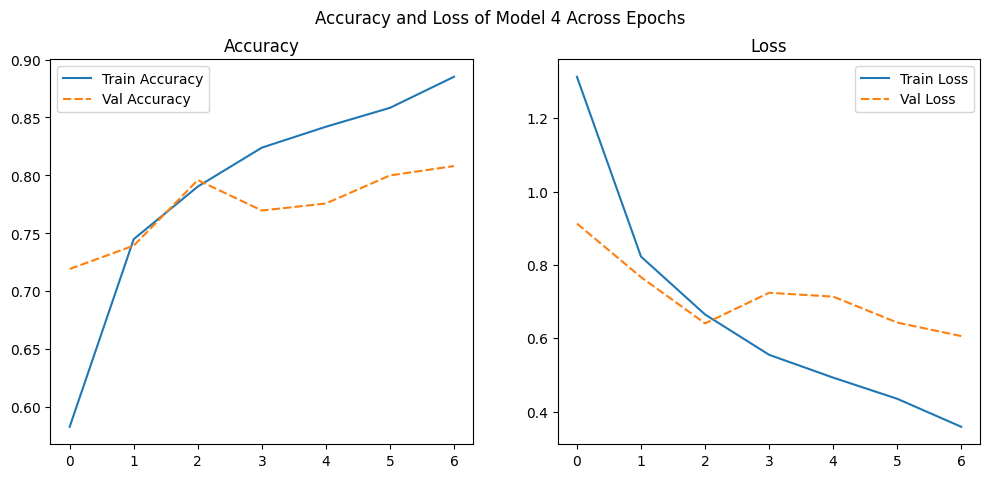

In [22]:
data_acc_4 = pd.DataFrame({"Train Accuracy": train_accs_4, "Val Accuracy": val_accs_4})
data_loss_4 = pd.DataFrame({"Train Loss": train_losses_4, "Val Loss": val_losses_4})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 4 Across Epochs")

sns.lineplot(data=data_acc_4, ax = axs[0])
axs[0].set_title("Accuracy")


sns.lineplot(data=data_loss_4, ax = axs[1])
axs[1].set_title("Loss")

In [23]:
result_4 = pd.concat([data_acc_4, data_loss_4], axis = 1)
result_4

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.582999,0.719192,1.312815,0.912536
1,0.744985,0.739394,0.822498,0.766431
2,0.790371,0.795960,0.664692,0.640447
3,0.823972,0.769697,0.554772,0.723847
4,0.842026,0.775758,0.492550,0.713432
5,0.858325,0.800000,0.434841,0.642618
6,0.885155,0.808081,0.358510,0.605767
